In [1]:
import tensorflow as tf
import os
import time
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
from nilearn import image
from nilearn import plotting
import nibabel as nib
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
from nilearn.image import concat_imgs, mean_img

/localhome/mkhademi/anaconda3/envs/tf/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
data_dir = '/local-scratch/localhome/mkhademi/BOLD5000_2.0/'
batch_size = 37
subjs = ['CSI1', 'CSI2', 'CSI3', 'CSI4'] 
sub = subjs[0]
#dataset = tf.data.TFRecordDataset(filenames = [data_dir + 'image_data/' + sub + 'bold5000_coco.tfrecords']).batch(batch_size)
#dataset_size = 2135
dataset = tf.data.TFRecordDataset(filenames = [data_dir + 'image_data/' + sub + 'bold5000_common.tfrecords']).batch(batch_size)
dataset_size = 2864
def tf_parse(eg):
    example = tf.io.parse_example(
        eg, {
            'x': tf.io.FixedLenFeature(shape=(71, 89, 72, 1), dtype=tf.float32),
            'yhat': tf.io.FixedLenFeature(shape=(1000), dtype=tf.float32),
            'y_coco': tf.io.FixedLenFeature(shape=(90), dtype=tf.int64),
            'y_imagenet': tf.io.FixedLenFeature(shape=(1000), dtype=tf.int64),
            'y_super': tf.io.FixedLenFeature(shape=(12), dtype=tf.int64),
            'y_common': tf.io.FixedLenFeature(shape=(90+12+1), dtype=tf.int64)
        })
    return example['x'], example['y_common']
dataset = dataset.unbatch().batch(10)
dataset = dataset.shuffle(512)
dataset = dataset.map(tf_parse)
def train_vis(dataset, j):
    train = dataset.map(lambda x, y:(x, tf.concat([y[:,j:j+1],tf.ones_like(y[:,j:j+1], dtype=tf.int64)-y[:,j:j+1]], axis=1))) 
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(71, 89, 72, 1)),
        # tf.keras.layers.LayerNormalization(),
        tf.keras.layers.Conv3D(1, 3, activation='relu', padding='same', name='conv1'),
        tf.keras.layers.Conv3D(2, 3, activation='relu', padding='same', name='conv2'),
        tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
        tf.keras.layers.Conv3D(4, 3, padding='same', name='conv3'),
        tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(2),
        ])
    model.summary()
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        optimizer='adam',
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )
    model.fit(train, epochs=60)
    return model

In [3]:
img4d = image.load_img(data_dir + sub + '_GLMbetas-TYPED-FITHRF-GLMDENOISE-RR_ses-01.nii.gz')
selected_volumes = image.index_img(img4d, slice(200, 201))
imgs = [img for img in image.iter_img(selected_volumes)]
img = imgs[0]
mask = np.zeros(img.shape) * image.get_data(img)
# plot_stat_map(img, threshold='auto', display_mode="z", cut_coords=4, bg_img=None)

In [4]:
baseline = tf.zeros(shape=(71, 89, 72, 1))
m_steps=10
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) 
def interpolate_images(baseline, fmri_image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(fmri_image, axis=0)
    delta = input_x - baseline_x
    fmri_images = baseline_x +  alphas_x * delta
    return fmri_images
def compute_gradients(model, images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [5]:
def integrated_gradients(model, baseline, fmri_image, target_class_idx, m_steps=10, batch_size=16):
    # Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
    # Collect gradients.    
    gradient_batches = []
    # Iterate alphas range and batch computation for speed, memory #efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]
        gradient_batch = one_batch(model, baseline, fmri_image, alpha_batch, target_class_idx)
        gradient_batches.append(gradient_batch)    
    total_gradients = tf.concat(gradient_batches, axis=0)
    # Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)
    # Scale integrated gradients with respect to input.
    integrated_gradients = (fmri_image - baseline) * avg_gradients
    return integrated_gradients

@tf.function
def one_batch(model, baseline, fmri_image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch=interpolate_images(baseline=baseline, fmri_image=fmri_image, alphas=alpha_batch)
    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(model, images=interpolated_path_input_batch, target_class_idx=target_class_idx)
    return gradient_batch

In [6]:
def ig_vis(model, dataset, j):
    train = dataset.map(lambda x, y:(x, tf.concat([y[:,j:j+1],tf.ones_like(y[:,j:j+1],dtype=tf.int64)-y[:,j:j+1]], axis=1)))
    vis_face = np.zeros((71, 89, 72))
    vis_face2 = np.zeros((71, 89, 72))
    count_face = 0
    count_noface = 0
    for x_batch, y_batch in train:
        for i in range(y_batch.shape[0]):
            if y_batch[i][0] == 1:
                ig_attributions = integrated_gradients(model, baseline=baseline, fmri_image=x_batch[i], target_class_idx=0)
                attribution_mask = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)
                vis_face += attribution_mask.numpy()
                vis_face2 += tf.reduce_sum(ig_attributions, axis=-1).numpy()
                count_face += 1
            else:
                count_noface += 1
    #vis_face = vis_face/count_face 
    nifti_file = nib.nifti1.Nifti1Image(dataobj=vis_face, affine=img.affine, header=img.header, extra=None,file_map=None)
    plot_stat_map(nifti_file, threshold=0, display_mode="z", cut_coords=4, bg_img=mean_img(img4d))
    plot_stat_map(nifti_file, threshold='auto', display_mode="z", cut_coords=4, bg_img=mean_img(img4d))
    nifti_file = nib.nifti1.Nifti1Image(dataobj=vis_face2, affine=img.affine, header=img.header, extra=None,file_map=None)
    plot_stat_map(nifti_file, threshold=0, display_mode="z", cut_coords=4, bg_img=mean_img(img4d))
    return

In [7]:
# model = train_vis(dataset, j=90)

In [8]:
# ig_vis(model, dataset, j=90)

In [9]:
model = train_vis(dataset, j=91)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv3D)              (None, 71, 89, 72, 1)     28        
                                                                 
 conv2 (Conv3D)              (None, 71, 89, 72, 2)     56        
                                                                 
 max_pooling3d (MaxPooling3D  (None, 35, 44, 36, 2)    0         
 )                                                               
                                                                 
 conv3 (Conv3D)              (None, 35, 44, 36, 4)     220       
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 17, 22, 18, 4)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 26928)             0

/localhome/mkhademi/anaconda3/envs/tf/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


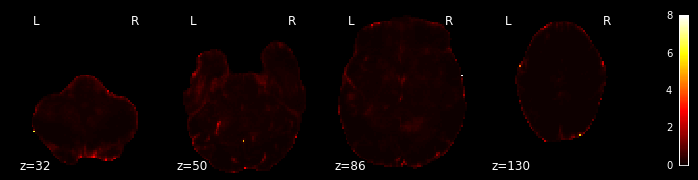

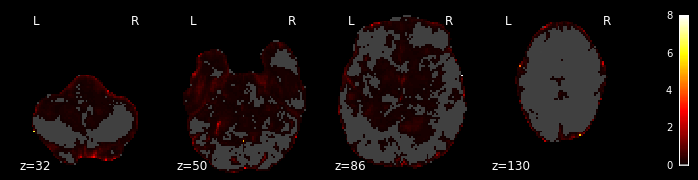

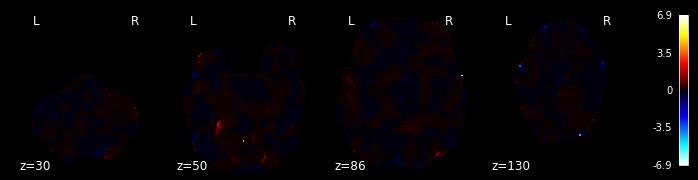

In [10]:
ig_vis(model, dataset, j=91)  # vehicle

In [11]:
model = train_vis(dataset, j=93) 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv3D)              (None, 71, 89, 72, 1)     28        
                                                                 
 conv2 (Conv3D)              (None, 71, 89, 72, 2)     56        
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 35, 44, 36, 2)    0         
 3D)                                                             
                                                                 
 conv3 (Conv3D)              (None, 35, 44, 36, 4)     220       
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 17, 22, 18, 4)    0         
 3D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 26928)            

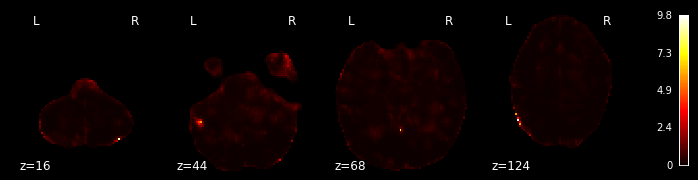

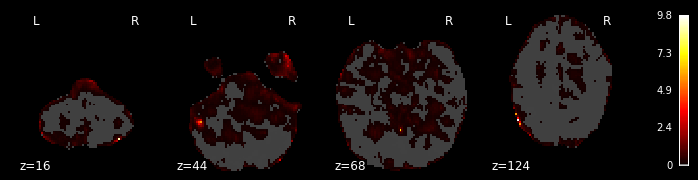

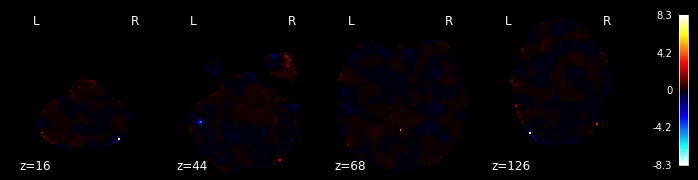

In [12]:
ig_vis(model, dataset, j=93) # animal

In [13]:
model = train_vis(dataset, j=95)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv3D)              (None, 71, 89, 72, 1)     28        
                                                                 
 conv2 (Conv3D)              (None, 71, 89, 72, 2)     56        
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 35, 44, 36, 2)    0         
 3D)                                                             
                                                                 
 conv3 (Conv3D)              (None, 35, 44, 36, 4)     220       
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 17, 22, 18, 4)    0         
 3D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 26928)            

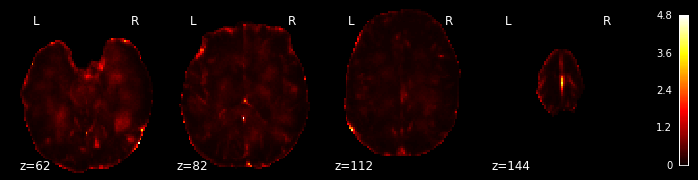

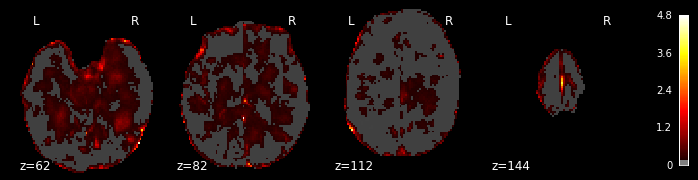

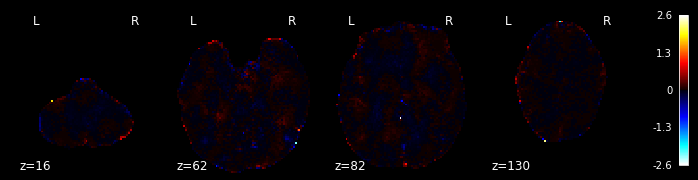

In [14]:
ig_vis(model, dataset, j=95) #sports